# Chapter 14: Recurrent neural network (RNN)

### 14.1. Intuition behind RNN
> ###### 14.1.1. How an RNN works?
> ###### 14.1.2. LSTM neuron
> ###### 14.1.3. GRU neuron

### 14.2. RNN for classification
> ###### 14.2.1. Transform 2-dimensional data to 3-dimensional data
> ###### 14.2.2. Implement the model
> ###### 14.2.3 Prediction and backtest

### 14.3. RNN for regression
> ###### 14.1.3. Precision about standardization
> ###### 14.2.3. Implement the model
> ###### 14.3.3. Prediction and backtest

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
from Backtest import *

In [2]:
# Import the data
df = yf.download("NFLX", end="2021-01-01")[["Adj Close"]].pct_change(1)
df.columns = ["returns"]

# Features engeeniring
df["returns t-1"] = df[["returns"]].shift(1)

# Mean of returns
df["mean returns 15"] = df[["returns"]].rolling(15).mean().shift(1)
df["mean returns 60"] = df[["returns"]].rolling(60).mean().shift(1)

# Volatility of returns
df["volatility returns 15"] = df[["returns"]].rolling(15).std().shift(1)
df["volatility returns 60"] = df[["returns"]].rolling(60).std().shift(1)

# Drop missing values
df = df.dropna()

# Percentage train set
split = int(0.80*len(df))

# Train set creation
X_train = df[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[:split]

y_train_reg = df[["returns"]].iloc[:split]

y_train_cla = np.round(df[["returns"]].iloc[:split]+0.5)


# Test set creation
X_test = df[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[split:]

y_test_reg = df[["returns"]].iloc[split:]
y_test_cla = np.round(df[["returns"]].iloc[split:]+0.5)


# NORMALIZATION 
# Import the class
from sklearn.preprocessing import StandardScaler

# Initialize the class
sc = StandardScaler()

# Standardize the data
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

[*********************100%***********************]  1 of 1 completed


### 14.2.1. Transform 2-dimensional data to 3-dimensional data

In [3]:
def X_3d_RNN(X_s, y_s, lag):

    # Simple verification
    if len(X_s) != len(y_s):
        print("Warnings")

    # Create the X_train
    X_train = []
    for variable in range(0, X_s.shape[1]):
        X = []
        for i in range(lag, X_s.shape[0]):
            X.append(X_s[i-lag:i, variable])
        X_train.append(X)
    X_train, np.array(X_train)
    X_train = np.swapaxes(np.swapaxes(X_train, 0, 1), 1, 2)

    # Create the y_train
    y_train = []
    for i in range(lag, y_s.shape[0]):
        y_train.append(y_s[i, :].reshape(-1,1).transpose())
    y_train = np.concatenate(y_train, axis=0)
    return X_train, y_train

lag = 15
X_train_3d, y_train_3d = X_3d_RNN(X_train_scaled, y_train_cla.values, 15)
X_test_3d, y_test_3d = X_3d_RNN(X_test_scaled, y_test_cla.values, 15)

print(np.shape(X_train_3d))
print(X_train_3d[0]) 

(3685, 15, 5)
[[ 1.93950614  0.71351913 -0.77784221  1.23103743  1.26165869]
 [-1.01127642  0.17252205 -0.93306896  1.24798543  1.27368605]
 [ 0.55944537  0.03942716 -0.71480774  1.20684454  1.26042575]
 [ 0.35157263  0.58788047 -0.51377656  1.03092452  1.23844637]
 [ 0.21174747  1.52337209 -0.38592647  0.16928005  1.22938969]
 [-0.73573805  1.37236073 -0.48532048  0.24190648  1.23734523]
 [-2.61604667  0.8352677  -0.95991084  0.75642793  1.31950949]
 [-0.33485802  0.46928214 -0.96360484  0.7216203   1.31970918]
 [ 1.13923826  0.75387945 -0.90095175  0.77859264  1.33775973]
 [ 0.90033657  1.08044565 -0.88190377  0.78345337  1.34286302]
 [-0.37628578  1.25661835 -0.74663679  0.69989645  1.31159546]
 [ 0.04598431  1.14173974 -0.84420032  0.70214794  1.2962901 ]
 [-0.35876102  0.52908296 -0.87370163  0.5188413   1.29733134]
 [-0.15774818  0.1005654  -0.71510866  0.38642401  1.26581102]
 [-0.4251084  -0.22612844 -0.73109148  0.34686871  1.26702237]]


### 14.2.2. Implement the model

In [4]:
# LIBAIRIES
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# INITIALIZATION OF THE MODEL
classifier = Sequential()

# ADD LSTM LAYER
classifier.add(LSTM(units = 10, return_sequences = True,
                    input_shape = (X_train_3d.shape[1],X_train_3d.shape[2],)))


# LOOP WHICH ADD LSTM LAYER
for _ in range(1):
    classifier.add(LSTM(units = 10, return_sequences = True))

# LAST LSTM LAYER BUT WITH return_sequences = False 
classifier.add(LSTM(units = 10, return_sequences = False))


# OUTPUT DENSE LAYER
classifier.add(Dense(1, activation="sigmoid"))

# COMPILE THE MODEL
classifier.compile(loss="binary_crossentropy", optimizer="adam")


# TRAINING
classifier.fit(X_train_3d, y_train_3d, epochs=1, batch_size=32, verbose=1)

116/116 [==============================] - 3s 7ms/step - loss: 0.6944


### 14.2.3. Predictions and backtest

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.953 	 Alpha: 28.52 %	     Sharpe: 1.04 	 Sortino: 1.539
  -----------------------------------------------------------------------------
    VaR: 52.92 %	 cVaR: 67.14 % 	     VaR/cVaR: 1.269 	 drawdown: 44.18 %
  -----------------------------------------------------------------------------


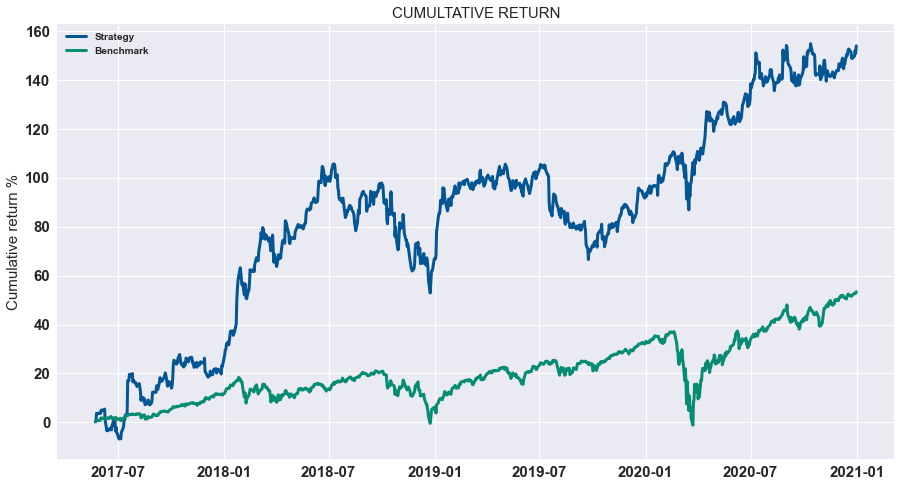

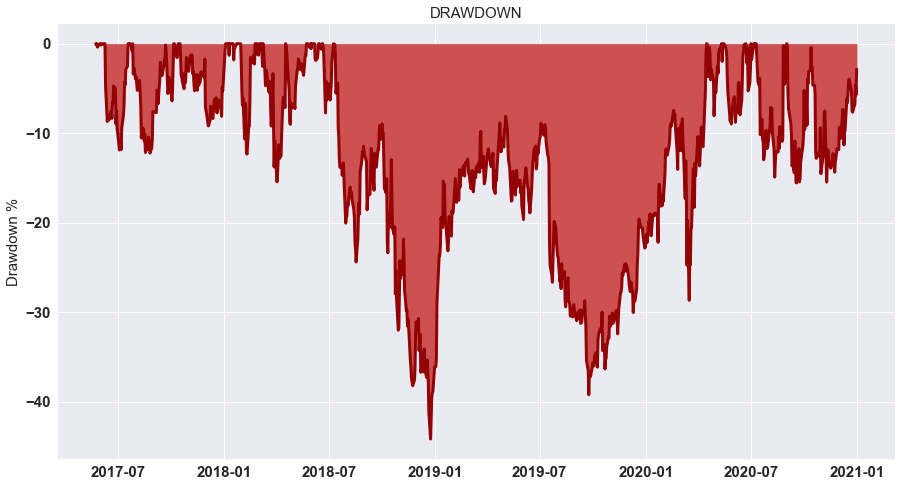

In [5]:
# Create predictions for the whole dataset
y_pred_train = np.concatenate((np.zeros([lag,1]),classifier.predict(X_train_3d)),
                                    axis=0)

y_pred_test = np.concatenate((np.zeros([lag,1]),classifier.predict(X_test_3d)),
                                    axis=0)


df["prediction"] = np.concatenate((y_pred_train,y_pred_test),
                                    axis=0)


df["prediction"] = np.where(df["prediction"] == 0, -1,1)
# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split+lag:])

### 14.3.1. Precision about standardization

In [6]:
# STANDARDIZATION 
sc_y = StandardScaler()
y_train_scaled = sc_y.fit_transform(y_train_reg)
y_test_scaled = sc_y.transform(y_test_reg)

lag = 15
X_train_3d, y_train_3d = X_3d_RNN(X_train_scaled, y_train_scaled, 15)
X_test_3d, y_test_3d = X_3d_RNN(X_test_scaled, y_test_scaled, 15)

In [7]:
def RNN(number_neurons, number_hidden_layer, shape, loss="mse", metrics=["mae"], activation="linear", optimizer="adam", pct_dropout=0.5):

    # LIBAIRIES
    import tensorflow
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Dropout

    # INITIALIZATION OF THE DATA
    model = Sequential()

    # ADD LSTM LAYER
    model.add(LSTM(units = number_neurons, return_sequences = True, input_shape = shape))

    # ADD DROPOUT LAYER
    model.add(Dropout(pct_dropout))

    # LOOP WHICH ADD LSTM AND DROPPOUT LAYER
    for _ in range(number_hidden_layer):
        model.add(LSTM(units = number_neurons, return_sequences = True))
        model.add(Dropout(pct_dropout))

    # LAST LSTM LAYER BUT WITH return_sequences = False
    model.add(LSTM(units = number_neurons, return_sequences = False))

    # ADD DROPOUT LAYER
    model.add(Dropout(pct_dropout))

    # OUTPUT DENSE LAYER
    model.add(Dense(1, activation=activation))

    # COMPILE THE MODEL
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

regressor = RNN(15, 3, shape = (X_train_3d.shape[1],X_train_3d.shape[2]),
                  loss = "mse", metrics=["mae"], activation="linear",
                  optimizer="adam", pct_dropout=0.65)

regressor.fit(X_train_3d, y_train_3d, epochs=1, batch_size=32, verbose=1)

116/116 [==============================] - 5s 13ms/step - loss: 1.0787 - mae: 0.6588


### 14.3.3. Predictions and backtest

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.953 	 Alpha: 28.52 %	     Sharpe: 1.04 	 Sortino: 1.539
  -----------------------------------------------------------------------------
    VaR: 53.14 %	 cVaR: 66.1 % 	     VaR/cVaR: 1.244 	 drawdown: 44.18 %
  -----------------------------------------------------------------------------


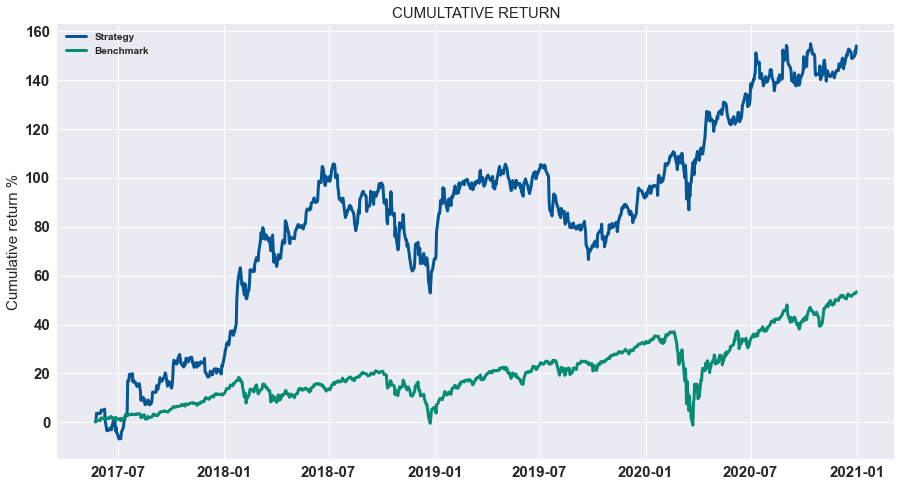

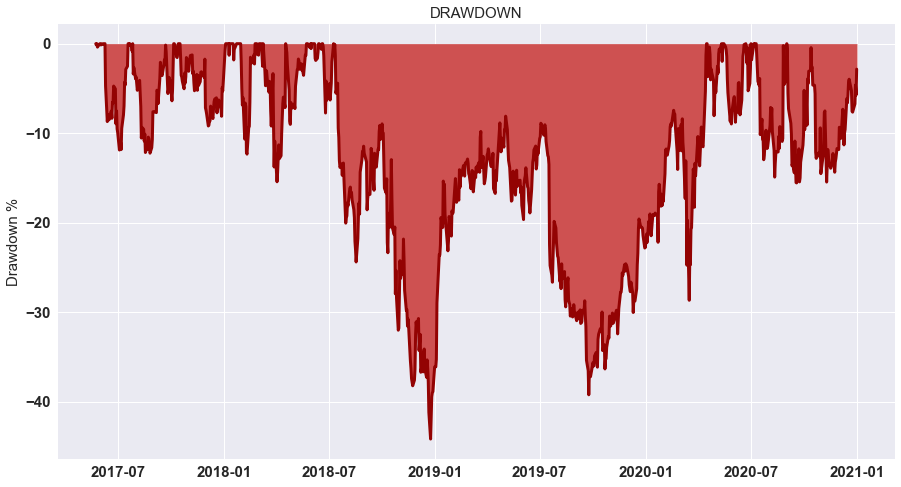

In [8]:
# Create predictions for the whole dataset

# Inverse transform
y_train_sc = sc_y.inverse_transform(regressor.predict(X_train_3d))

# Predictions
y_pred_train = np.concatenate((np.zeros([lag,1]),y_train_sc),
                                    axis=0)

# Inverse transform
y_test_sc = sc_y.inverse_transform(regressor.predict(X_test_3d))

# Predictions
y_pred_test = np.concatenate((np.zeros([lag,1]),y_test_sc),
                                    axis=0)


df["prediction"] = np.concatenate((y_pred_train,y_pred_test),
                                    axis=0)


# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split+lag:])